# Convolution Image Net

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from utils.nn_visualization import variable_summaries
from utils.data import init_model_logging
from utils.nn_graph import simple_layer
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import pandas as pd
import matplotlib.pylab as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Preprocess data

In [2]:
class Reshape(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image.reshape(1, 28, 28)
        return {'image': image, 
                'label': label}
        
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)} 
    
transform = Compose([Reshape(), ToTensor()])

## Load data

In [3]:
class_id2class_name_mapping = {
            0: 'T-shirt/top',
            1: 'Trouser',
            2: 'Pullover',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle boot'}

In [5]:
class FashionMnistDataset(Dataset):
    def __init__(self, raw_data, transform=None):
        self.raw_data = raw_data
        self.transform = transform

    def __len__(self):
        return self.raw_data.num_examples
    
    def __getitem__(self, idx):
        item = {'image': self.raw_data.images[idx], 
                'label': self.raw_data.labels[idx]}
        if self.transform is not None:
            return transform(item)
        else:
            return item

In [7]:
raw_fashion_mnist_dataset = input_data.read_data_sets('/data/fashion/', one_hot=True, reshape=False)
train_data = FashionMnistDataset(raw_fashion_mnist_dataset.train, transform=transform)
valid_data = FashionMnistDataset(raw_fashion_mnist_dataset.validation, transform=transform)

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Batch data

In [8]:
train_data_batcher = DataLoader(train_data, batch_size=32, shuffle=True)
valid_data_batcher = DataLoader(valid_data, batch_size=32, shuffle=False)

In [9]:
iter(train_data_batcher).next()

{'image': tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
 
 
         [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0039,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0039,  0.0000],
           ...,
           [ 0.0000,  0.4196,  0.8431,  ...,  0.6314,  0.7020,  0.4235],
           [ 0.0000,  0.4000,  1.0000,  ...,  0.6784,  0.8275,  0.3490],
           [ 0.0000,  0.0000,  0.1059,  ...,  0.1020,  0.0235,  0.0000]]],
 
 
         [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]

## Basic conv and feed forward model

In [15]:
dtype = torch.float
device = torch.device("cpu")

In [16]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
       
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x
    
class FFNet(nn.Module):
    def __init__(self):
        super(FFNet, self).__init__()
        
        self.w = torch.empty(64 * 5 * 5, 10, device=device, dtype=dtype, requires_grad=True)
        self.w = torch.nn.init.xavier_normal_(self.w)
        self.w = torch.nn.Parameter(self.w)
        
        self.b = torch.zeros(10, device=device, dtype=dtype, requires_grad=True)
        self.b = torch.nn.Parameter(self.b)
        
    def forward(self, x):
        x = x.view((-1, 64 * 5 * 5))
        return x.mm(self.w) + self.b
        

In [17]:
conv_net = ConvNet()
ff_net = FFNet()

## Loss and optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(conv_net.parameters()) + list(ff_net.parameters()), lr=0.001)

## Training

In [19]:
for epoch_id in range(25):
    for iteration, batch in enumerate(train_data_batcher, 1):
        images, labels = batch['image'], batch['label']
        labels = torch.max(labels, 1)[1]
        
        conv_layer = conv_net(images)
        outputs = ff_net(conv_layer)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if iteration % 30 == 0:
            correct_match = []
            with torch.no_grad():
                for valid_batch in valid_data_batcher:
                    images, labels = valid_batch['image'], valid_batch['label']
                    labels = torch.max(labels, 1)[1]

                    conv_layer = conv_net(images)
                    outputs = ff_net(conv_layer)
                    correct_match += (torch.max(outputs, 1)[1] == labels).squeeze().numpy().tolist()
                
                print("accuracy ", np.mean(np.array(correct_match)))
            break

accuracy  0.615
accuracy  0.646
accuracy  0.7166
accuracy  0.7372
accuracy  0.7416
accuracy  0.7722
accuracy  0.7922
accuracy  0.798
accuracy  0.8076
accuracy  0.7986
accuracy  0.795
accuracy  0.814
accuracy  0.8202
accuracy  0.8118
accuracy  0.828
accuracy  0.831
accuracy  0.8408
accuracy  0.835
accuracy  0.8214
accuracy  0.8468
accuracy  0.8416
accuracy  0.845
accuracy  0.852
accuracy  0.8494
accuracy  0.846


## Prediction

In [20]:
with torch.no_grad():
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for valid_batch in valid_data_batcher:
        images, labels = valid_batch['image'], valid_batch['label']
        labels = torch.max(labels, 1)[1]

        conv_layer = conv_net(images)
        outputs = ff_net(conv_layer)
        
        correct_match = (torch.max(outputs, 1)[1] == labels).squeeze()
        for idx in range(correct_match.shape[0]):
            label = labels[idx]
            class_correct[label] += correct_match[idx].item()
            class_total[label] += 1
    for i in range(10):
        print('Accuracy of class {0} : {1:.2f}'.format(class_id2class_name_mapping[i], 100 * class_correct[i] / class_total[i]))
            


Accuracy of class T-shirt/top : 87.75
Accuracy of class Trouser : 97.84
Accuracy of class Pullover : 66.27
Accuracy of class Dress : 84.63
Accuracy of class Coat : 63.32
Accuracy of class Sandal : 96.55
Accuracy of class Shirt : 64.30
Accuracy of class Sneaker : 91.02
Accuracy of class Bag : 94.90
Accuracy of class Ankle boot : 97.63


## Results evaluation

In [21]:
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_accuracy
from utils.results_evaluation import get_false_positives
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_rec_prec
from utils.results_evaluation import plot_coocurance_matrix
from utils.results_evaluation import plot_examples 

In [23]:
validation_images  = torch.from_numpy(valid_data.raw_data.images.reshape(-1, 1, 28, 28))
conv_layer = conv_net(validation_images)
outputs = ff_net(conv_layer)

_prediction = torch.nn.functional.softmax(outputs, dim=1)
_prediction = _prediction.detach().numpy()

In [24]:
df = get_info_df(valid_data.raw_data.labels, _prediction, class_id2class_name_mapping, valid_data.raw_data.images)

In [25]:
get_accuracy(df)

84.6

In [26]:
get_rec_prec(df, class_id2class_name_mapping)

,class_name,precision,recall
0,T-shirt/top,73.85,87.75
1,Trouser,96.28,97.84
2,Pullover,79.71,66.27
3,Dress,90.41,84.63
4,Coat,81.32,63.32
5,Sandal,95.58,96.55
6,Shirt,51.05,64.30
7,Sneaker,97.08,91.02
8,Bag,93.37,94.90
9,Ankle boot,93.74,97.63


In [27]:
fp = get_false_positives(df, 'Shirt')

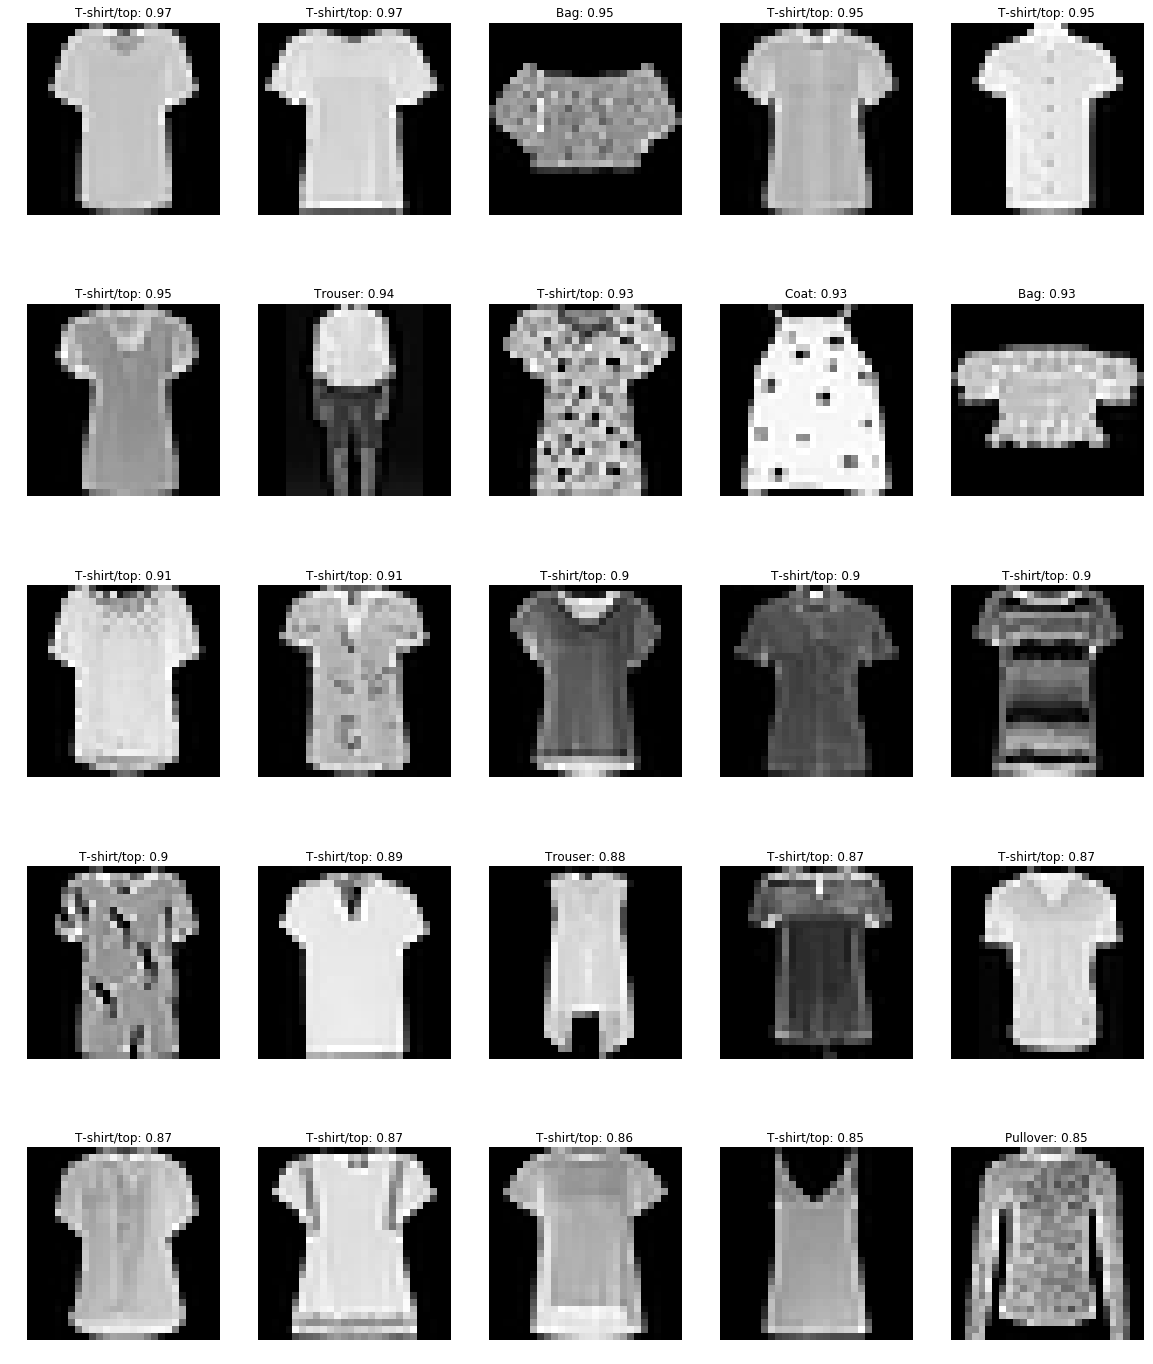

In [28]:
plot_examples(fp)

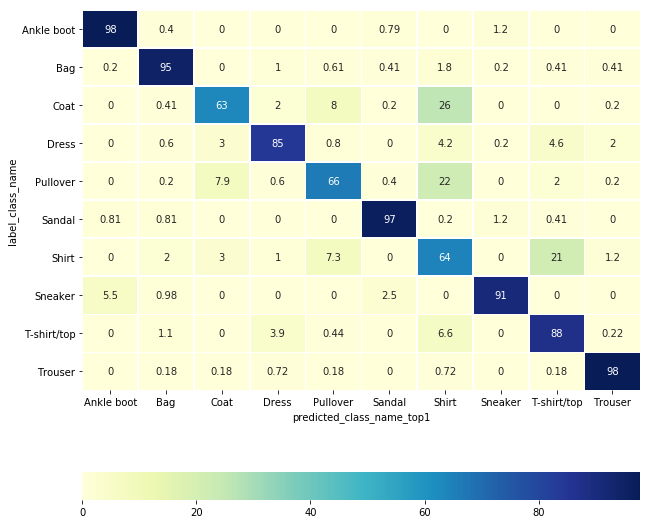

In [29]:
plot_coocurance_matrix(df, use_top3=False, use_log=False)